In [1]:
import os
import random
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# Reproducibilidad 
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Rutas
DATA_ROOT = Path("data/chest_xray")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "val"   
TEST_DIR  = DATA_ROOT / "test"

In [4]:
# Hiperparámetros
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 10  #Determina N° de Épocas

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [5]:
# Chequeo de estructura y conteo
def print_split_counts(root: Path):
    if not root.exists():
        print(f"{root.name} no existe.")
        return
    print(f"{root.name} folders:")
    for cls in sorted(os.listdir(root)):
        cls_path = root / cls
        if cls_path.is_dir():
            n = len(os.listdir(cls_path))
            print(f"  {cls}: {n} imágenes")

for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print_split_counts(split_dir)

train folders:
  NORMAL: 1339 imágenes
  PNEUMONIA: 390 imágenes
val no existe.
test folders:
  NORMAL: 234 imágenes
  PNEUMONIA: 390 imágenes


In [6]:
# Definir transformations
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

In [7]:
# 3) Cargar datasets (ImageFolder) y crear split estratificado si no hay val/
# ============================================================
# Dataset base de train (con transform de TRAIN)
train_base = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_tfms)
test_dataset = datasets.ImageFolder(root=str(TEST_DIR), transform=eval_tfms)

# Si no existe VAL_DIR en disco, hacer un split estratificado desde train
if VAL_DIR.exists():
    val_dataset = datasets.ImageFolder(root=str(VAL_DIR), transform=eval_tfms)
    # train_dataset ya lo tenemos con augment; val_dataset con eval_tfms
    train_dataset = train_base
else:
    # Crear índices estratificados 80/20 desde train_base
    try:
        targets = train_base.targets
    except AttributeError:
        targets = [s[1] for s in train_base.samples]

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    idx_train, idx_val = next(sss.split(np.zeros(len(targets)), targets))

    # Subsets: train con augment; val con eval_tfms (igual base de archivos)
    train_dataset = Subset(train_base, idx_train)

    # Creamos un dataset val reutilizando paths pero con eval_tfms
    val_base_only_paths = datasets.ImageFolder(root=str(TRAIN_DIR), transform=eval_tfms)
    val_dataset = Subset(val_base_only_paths, idx_val)

# Chequeo de clases
classes = train_base.classes
print("Clases:", classes)  


# DataLoaders optimizados

PIN = torch.cuda.is_available()
NUM_WORKERS = 2 if os.name == "nt" else 4  

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)

# Sanity check de un batch
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape, "Labels shape:", labels.shape)

Clases: ['NORMAL', 'PNEUMONIA']
Batch shape: torch.Size([32, 3, 224, 224]) Labels shape: torch.Size([32])


In [9]:
# 5) Modelo (ResNet18) + pérdida con pesos de clase (robusta)
def get_train_targets(dataset, base_dataset):
    """Recupera etiquetas verdaderas del conjunto de entrenamiento (compat Subset/ImageFolder)."""
    try:
        base_targets = base_dataset.targets
    except AttributeError:
        base_targets = [s[1] for s in base_dataset.samples]
    if isinstance(dataset, Subset):
        return [base_targets[i] for i in dataset.indices]
    else:
        return base_targets

train_targets = get_train_targets(train_dataset, train_base)
counts = Counter(train_targets)
print("Distribución de clases en train:", counts)

n0, n1 = counts.get(0, 0), counts.get(1, 0)
total = n0 + n1
w0 = total / (2.0 * n0) if n0 > 0 else 1.0
w1 = total / (2.0 * n1) if n1 > 0 else 1.0
class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=device)
print("Pesos de clase:", class_weights)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 clases
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

device_type = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (device_type == "cuda")
scaler = torch.amp.GradScaler(device="cuda", enabled=use_amp)  

Distribución de clases en train: Counter({0: 1071, 1: 312})
Pesos de clase: tensor([0.6457, 2.2163])


In [10]:
# Métricas 
def get_probs_and_preds(logits: torch.Tensor):
    """Devuelve (probabilidad de clase positiva, predicciones discretas)."""
    probs = torch.softmax(logits, dim=1)[:, 1]
    preds = torch.argmax(logits, dim=1)
    return probs, preds

def eval_loader_metrics(model, loader, device, pos_label=1):
    """Evalúa en un loader y devuelve métricas + imprime resumen."""
    model.eval()
    all_y, all_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            _, preds = get_probs_and_preds(logits)
            all_y.append(y.cpu()); all_pred.append(preds.cpu())

    y_true = torch.cat(all_y).numpy()
    y_pred = torch.cat(all_pred).numpy()

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                       average="binary", pos_label=pos_label)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    print("\n📊 Métricas:")
    print(f"  Accuracy:     {acc:.4f}")
    print(f"  Precision:    {prec:.4f}")
    print(f"  Recall:       {rec:.4f}")
    print(f"  F1-score:     {f1:.4f}")
    print(f"  Matriz de confusión:\n{cm}")

    return {"acc": acc, "precision": prec, "recall": rec, "f1": f1}


📊 Métricas:
  Accuracy:     0.9971
  Precision:    0.9873
  Recall:       1.0000
  F1-score:     0.9936
  Matriz de confusión:
[[267   1]
 [  0  78]]

===== Epoch 1/10 =====
Loss (train): 0.0116
Val    - Acc: 0.9971 | F1: 0.9936

📊 Métricas:
  Accuracy:     0.9769
  Precision:    0.9070
  Recall:       1.0000
  F1-score:     0.9512
  Matriz de confusión:
[[260   8]
 [  0  78]]

===== Epoch 2/10 =====
Loss (train): 0.0119
Val    - Acc: 0.9769 | F1: 0.9512

📊 Métricas:
  Accuracy:     0.9942
  Precision:    0.9872
  Recall:       0.9872
  F1-score:     0.9872
  Matriz de confusión:
[[267   1]
 [  1  77]]

===== Epoch 3/10 =====
Loss (train): 0.0105
Val    - Acc: 0.9942 | F1: 0.9872

📊 Métricas:
  Accuracy:     0.9942
  Precision:    0.9872
  Recall:       0.9872
  F1-score:     0.9872
  Matriz de confusión:
[[267   1]
 [  1  77]]

===== Epoch 4/10 =====
Loss (train): 0.0030
Val    - Acc: 0.9942 | F1: 0.9872

📊 Métricas:
  Accuracy:     0.9942
  Precision:    1.0000
  Recall:       0.974

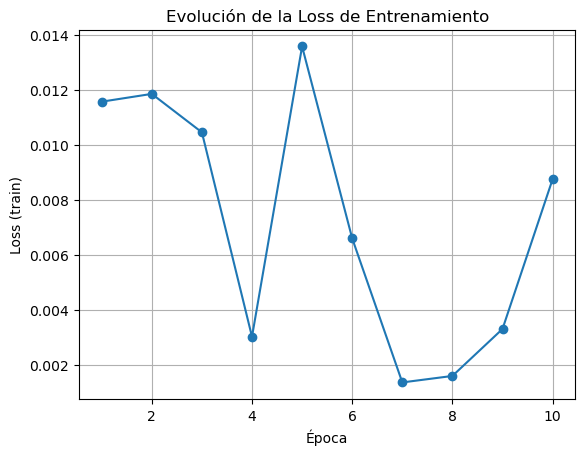

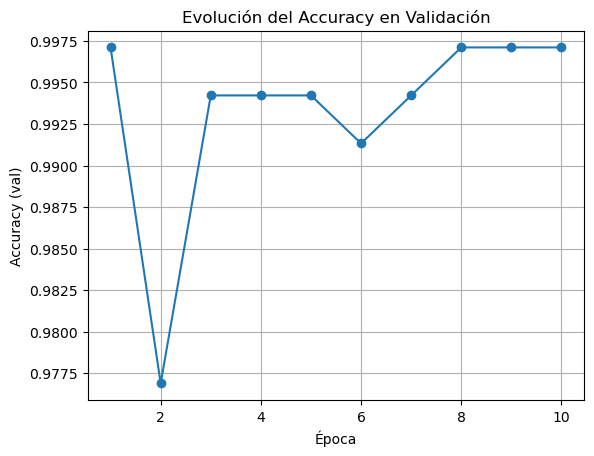

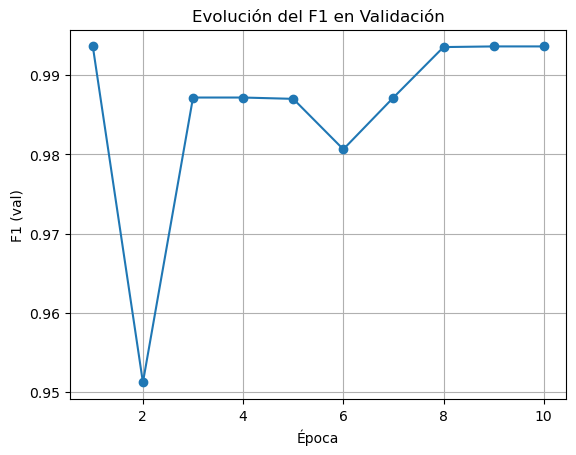


=== Evaluación final en TEST ===

📊 Métricas:
  Accuracy:     0.9247
  Precision:    0.8924
  Recall:       1.0000
  F1-score:     0.9432
  Matriz de confusión:
[[187  47]
 [  0 390]]


In [15]:
# 7) Entrenamiento + registro de métricas
# ============================================================
hist_epochs, hist_train_loss, hist_val_acc, hist_val_f1 = [], [], [], []
best_f1 = -np.inf

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        if use_amp:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * x.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    metrics = eval_loader_metrics(model, val_loader, device, pos_label=1)

    # Log
    hist_epochs.append(epoch)
    hist_train_loss.append(train_loss)
    hist_val_acc.append(metrics["acc"])
    hist_val_f1.append(metrics["f1"])

    # Guardar mejor modelo por F1
    if metrics["f1"] > best_f1:
        best_f1 = metrics["f1"]
        torch.save(model.state_dict(), "best_model_resnet18.pth")

    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")
    print(f"Loss (train): {train_loss:.4f}")
    print(f"Val    - Acc: {metrics['acc']:.4f} | F1: {metrics['f1']:.4f}")

# Gráficos de evolución

plt.figure()
plt.plot(hist_epochs, hist_train_loss, marker='o')
plt.xlabel("Época"); plt.ylabel("Loss (train)")
plt.title("Evolución de la Loss de Entrenamiento")
plt.grid(True); plt.show()

plt.figure()
plt.plot(hist_epochs, hist_val_acc, marker='o')
plt.xlabel("Época"); plt.ylabel("Accuracy (val)")
plt.title("Evolución del Accuracy en Validación")
plt.grid(True); plt.show()

plt.figure()
plt.plot(hist_epochs, hist_val_f1, marker='o')
plt.xlabel("Época"); plt.ylabel("F1 (val)")
plt.title("Evolución del F1 en Validación")
plt.grid(True); plt.show()

# ============================================================
# 9) Evaluación final en TEST (carga mejor modelo)
# ============================================================
model.load_state_dict(torch.load("best_model_resnet18.pth", map_location=device))
print("\n=== Evaluación final en TEST ===")
_ = eval_loader_metrics(model, test_loader, device, pos_label=1)

Se obtiene de las métricas globales:
Accuracy de 92.4%, en general de cada 10 radiografías el modelo acierta en 9.
Precision de 89.2% de todos los casos predichos como neumonía, el 89% realmente lo son (11% de falsos positivos)
Recall de 100%, lo que indica que el modelo detecta todas las neumonías.
F1-Score de 94.3%, indicando buen baleance entre precisión y recall.
Del análisis de la matriz de confusión de desprende:
187  47 Clase 0 (NORMAL) 187 bien clasificados, 47 mal clasificados como neumonia.
0  3901 Clase 1 (PNEUMONIA) 390 bien clasificados, 0 mal clasificados como normal.

El modelo es bueno detectando neumonía, pero se observa una tendencia a sobre-diagnosticar neumonía.